<a href="https://colab.research.google.com/github/Meire-Rosa/BootcampCienciaDadosInteligenciaArtificialUNISENAI_SC/blob/main/Rosemeire_Entrega_ProjetoBootcampUNISENAI_SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bibliotecas e instalações

In [1]:
!pip install -q -U catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    hamming_loss,
    roc_auc_score
)




##Funções

In [3]:
#Função para analisar os nulos.
def analisa_nulos(df):
    """
    Retorna um DataFrame com a contagem absoluta e percentual de valores nulos
    em cada coluna do DataFrame.

    Parâmetros:
        df (pd.DataFrame): DataFrame a ser analisado

    Retorna:
        pd.DataFrame: com colunas ['nulos_absolutos', 'percentual_nulos(%)']
    """
    nulos_df = pd.DataFrame({
        'nulos_absolutos': df.isnull().sum(),
        'percentual_nulos(%)': ((df.isnull().sum() / len(df)) * 100).round(2)
    })

    # Filtra apenas colunas que possuem nulos
    nulos_df = nulos_df[nulos_df['nulos_absolutos'] > 0] \
        .sort_values(by='percentual_nulos(%)', ascending=False)

    return nulos_df

## Função para criação de boxplot com histograma

def boxplot_com_estatisticas(df, colunas):
    """
    Gera boxplots + histogramas de várias variáveis numéricas em um único gráfico.
    junto com estatísticas resumo (média, mediana, std, min, max).

    Parâmetros:
        df (pd.DataFrame): DataFrame com os dados
        colunas (list): Lista com até 4 nomes de colunas numéricas
    """
    n = len(colunas)
    ncols = 2 #Cada variável terá dois gráficos (boxplot + histograma)
    nrows = n #Uma linha por variável

    # Criar figura
    plt.figure(figsize=(12, 5*nrows))

    for i, col in enumerate(colunas):
        plt.subplot(nrows, ncols, 2*i+1)
        sns.boxplot(y=df[col], color="skyblue")
        plt.title(f"Boxplot - {col}")

        # Estatísticas resumo
        media = df[col].mean()
        mediana = df[col].median()
        desvio = df[col].std()
        minimo = df[col].min()
        maximo = df[col].max()

        # Inserir texto com estatísticas no gráfico
        texto = (f"Média: {media:.2f}\n"
                 f"Mediana: {mediana:.2f}\n"
                 f"Std: {desvio:.2f}\n"
                 f"Mín: {minimo:.2f}\n"
                 f"Máx: {maximo:.2f}")

        plt.gca().text(
            1.05, 0.5, texto, transform=plt.gca().transAxes,
            fontsize=10, va="center", bbox=dict(facecolor="white", alpha=0.6)
        )

         # === Histograma ===
        plt.subplot(nrows, ncols, 2*i + 2)
        sns.histplot(df[col], kde=True, color="coral", bins=30)
        plt.title(f"Histograma - {col}")
        plt.xlabel(col)
        plt.ylabel("Frequência")

    plt.tight_layout()
    plt.show()

## Função que avalia o impacto que a retirada dos outliers causa no conjunto de dados.

def impacto_outliers(df, colunas):
    """
    Avalia quantos registros seriam removidos de cada coluna usando o critério de IQR.

    Parâmetros:
        df (pd.DataFrame): DataFrame original
        colunas (list): Lista de colunas numéricas a analisar
    """
    resultados = []

    for col in colunas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Contar quantos registros seriam removidos
        total_removido = (df[col]<limite_inferior).sum()
        percentual_removido = (total_removido / len(df)) * 100

        resultados.append({
            'coluna': col,
            'registros_removidos': total_removido,
            'percentual_removido': round(percentual_removido, 2)
        })

    return pd.DataFrame(resultados).sort_values(by='percentual_removido', ascending=False)

#Função que faz o plot da matriz de correlação.

def plot_correlation_matrix(df):
    corr_df = df[df.select_dtypes(include=['float']).columns]  # Apenas atributos contínuos
    plt.figure(figsize=(10, 8))
    correlation_matrix = corr_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlação')
    plt.show()

#Função que mostra as métricas dos modelos treinados
# ========= Função de Avaliação =========
def avaliar_modelo(nome, modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    # Métricas
    roc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    print(f"\n===== {nome} =====")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"F1 (classe 1): {f1:.4f}")

    # Curva Precision-Recall
    plt.plot(recall, precision, label=f"{nome} (PR-AUC={pr_auc:.3f})")

    return {"modelo": nome, "roc_auc": roc, "pr_auc": pr_auc, "f1": f1}

## Carregamento e leitura dos Dados

In [4]:
from google.colab import files
uploaded = files.upload()

Saving bootcamp_train.csv to bootcamp_train.csv


In [79]:
df = pd.read_csv('bootcamp_train.csv')

## Tratamento dos dados

In [80]:
#Remoção das duplicatas
df = df.drop_duplicates(subset=['tipo', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina', 'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)'])

#Análise dos nulos
resultado = analisa_nulos(df)
#print(resultado)



#### Anotações:

Existem valores nulos nas colunas: desgaste_da_ferramenta (2.7%), velocidade_rotacional(2.13%), torque(1.77%), temperatura_ar(1.75%) e temperatura_processo(1.7%).

#### Tratamento de Valores Ausentes e Duplicados.

Nosso conjunto de dados possui 8 (0.02% dos dados) valores duplicados, com id diferentes. Isso pode ocorrer com um duplo enter ao registrar um dado. Por isso, esses registros duplicados serão deletados.

Quanto aos dados ausentes, observamos um total de 10.05% de dados ausentes distribuídos em 5 colunas. Uma alternativa seria excluir esses valores do conjunto de dados, mas com isso, perdemos 3.543 linhas, o que é um número muito alto de informações. Desse modo, como os nulos não estão concentrados em uma única coluna crítica, o mais recomendado é preencher com a mediana ou a média e manter o dataset inteiro. Para decidir entre média ou mediana, vamos analisar a distribuição de cada coluna, para saber se sua distribuição é simétrica ou assimétrica para decidir entre a média ou a mediana.

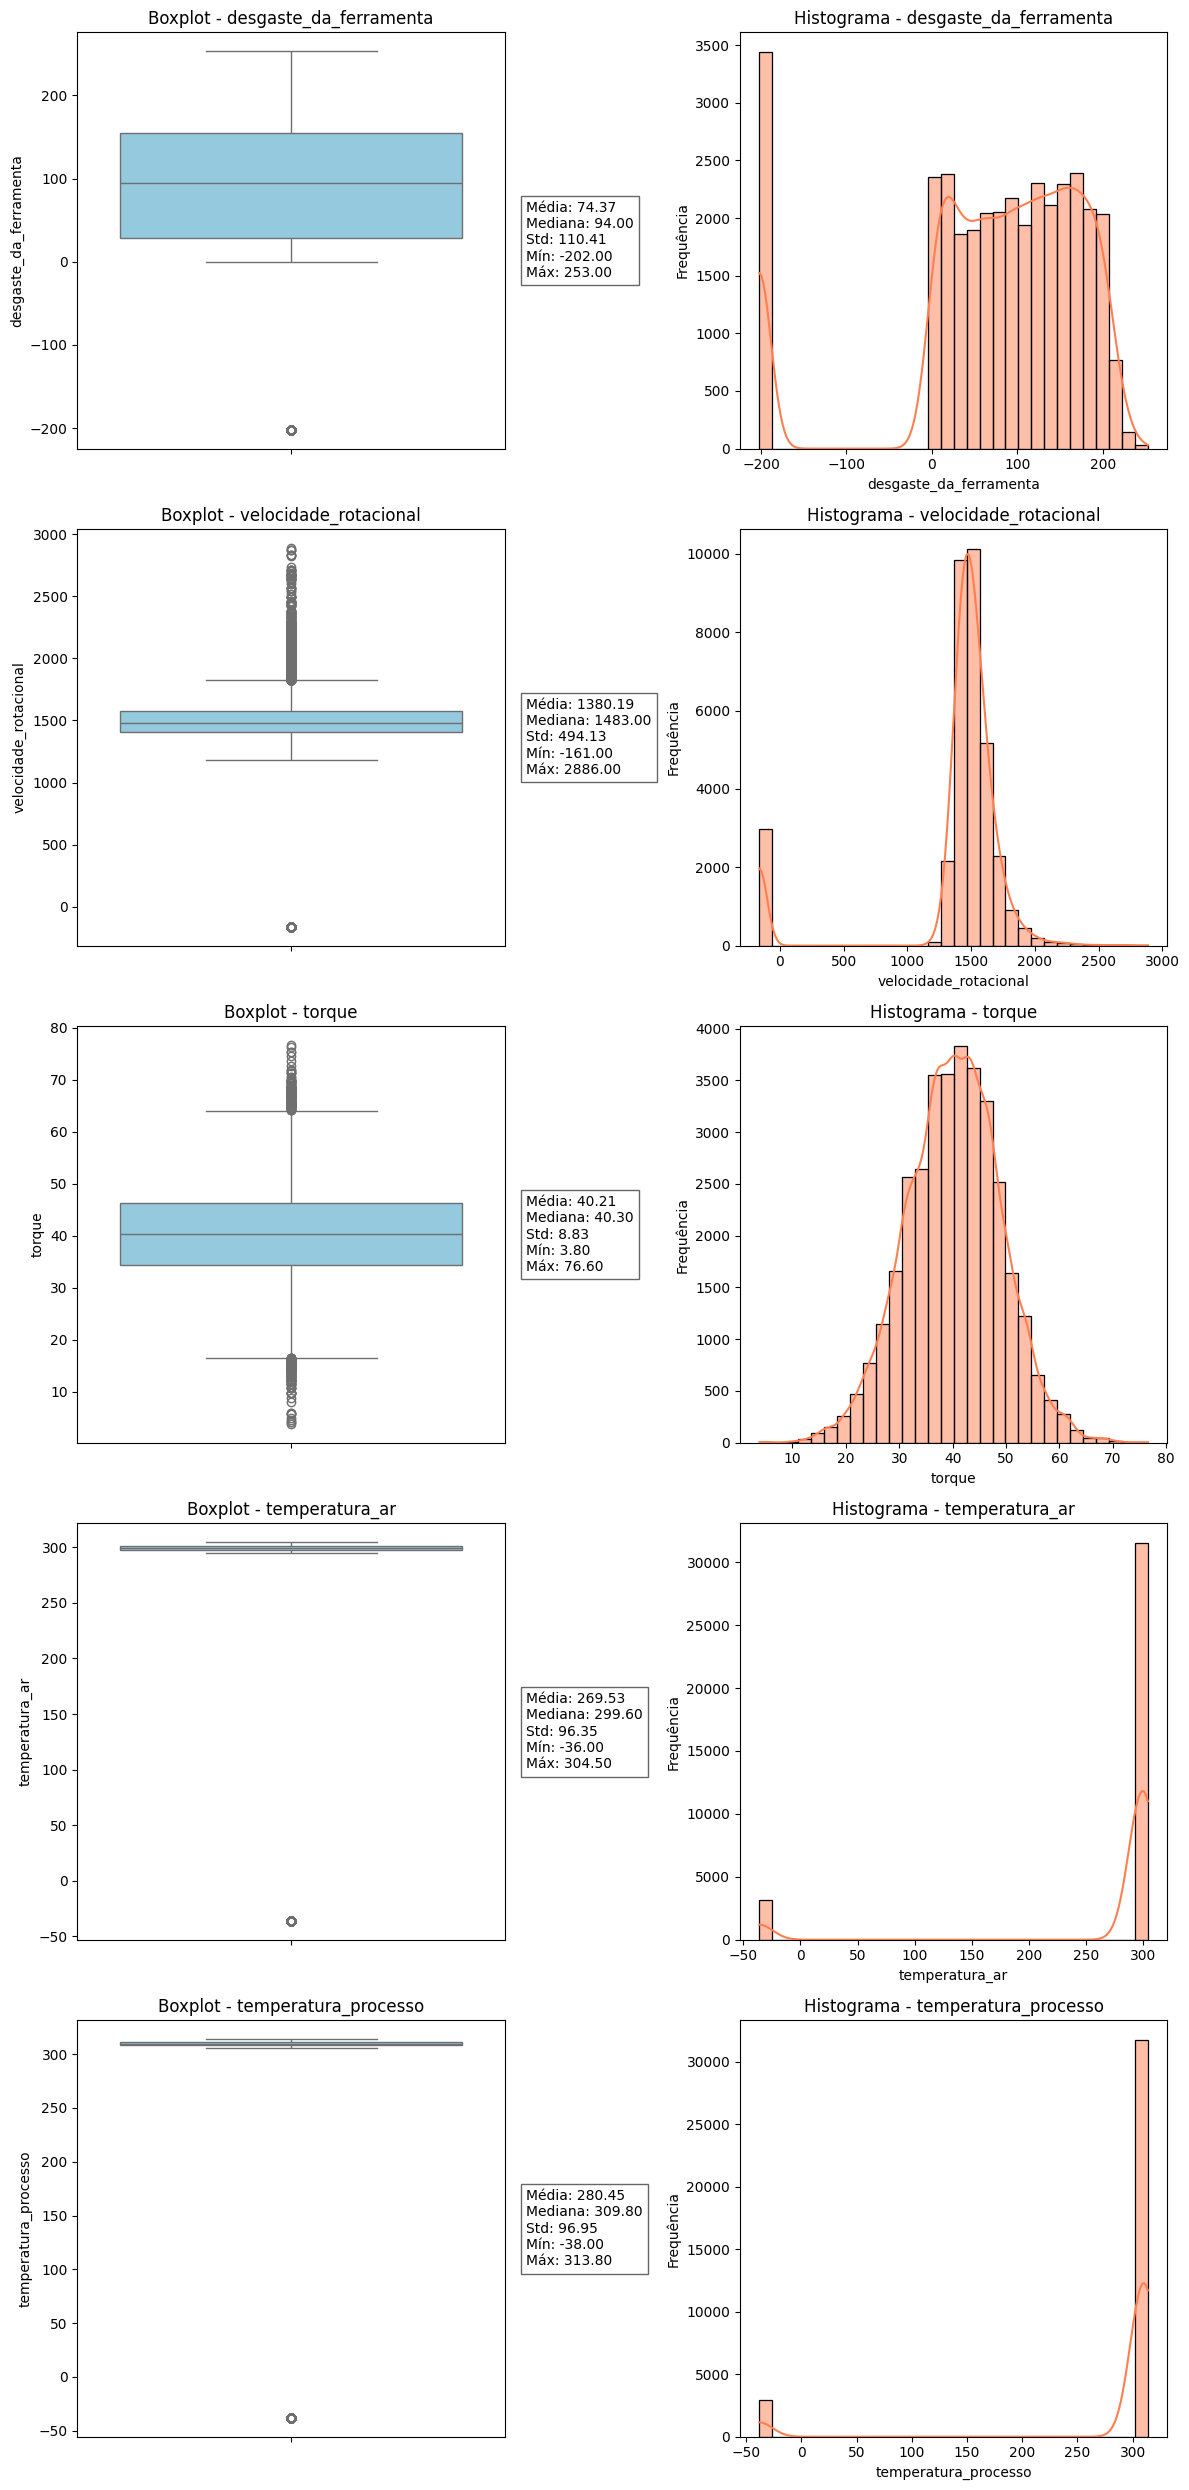

In [82]:
#Análise de box plot e histograma para análise de outliers e distribuição.
boxplot_com_estatisticas(df,['desgaste_da_ferramenta', 'velocidade_rotacional', 'torque', 'temperatura_ar', 'temperatura_processo'] )

#### Anotações

Variável 'desgaste_da_ferramenta'. Exclusão dos outliers inferiores. Pode se  observar que o valor mínimo é negativo, o que não faz sentido para uma variável  medida pelo tempo, em minutos. Pelo respectivo histograma, podemos substituir os valores nulos pela média dos dados.

Variável 'velocidade_rotacional'. Exclusão dos outliers inferiores. O valor mínimo da variável é negativo, que também não faz sentido, uma vez que não estamos falando em sentido (horário ou antihorário) da velocidade. Pelo respectivo histograma, vamos substituir os valores nulos pela média dos dados.

Variável 'torque'. Sem exclusão dos outliers, uma vez que o comportamento da variável é normal. Seus valores ausentes serão substituídos pela média dos dados.

Variável 'temperatura_ar'. Exclusão dos outliers inferiores. Após a remoção, vamos analisar a melhor medida para substituir os nulos.

Variável 'temperatura_processo'. Exclusão dos outliers inferiores. Após a remoção, vamos analisar a melhor medida para substituir os nulos.  


In [84]:
#Remoção dos outliers inferiores

colunas = ['desgaste_da_ferramenta', 'velocidade_rotacional', 'temperatura_ar', 'temperatura_processo']

df_filtrado = df.copy()

for col in colunas:
    Q1 = df_filtrado[col].quantile(0.25)
    Q3 = df_filtrado[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_filtrado = df_filtrado[(df_filtrado[col] >= limite_inferior)]

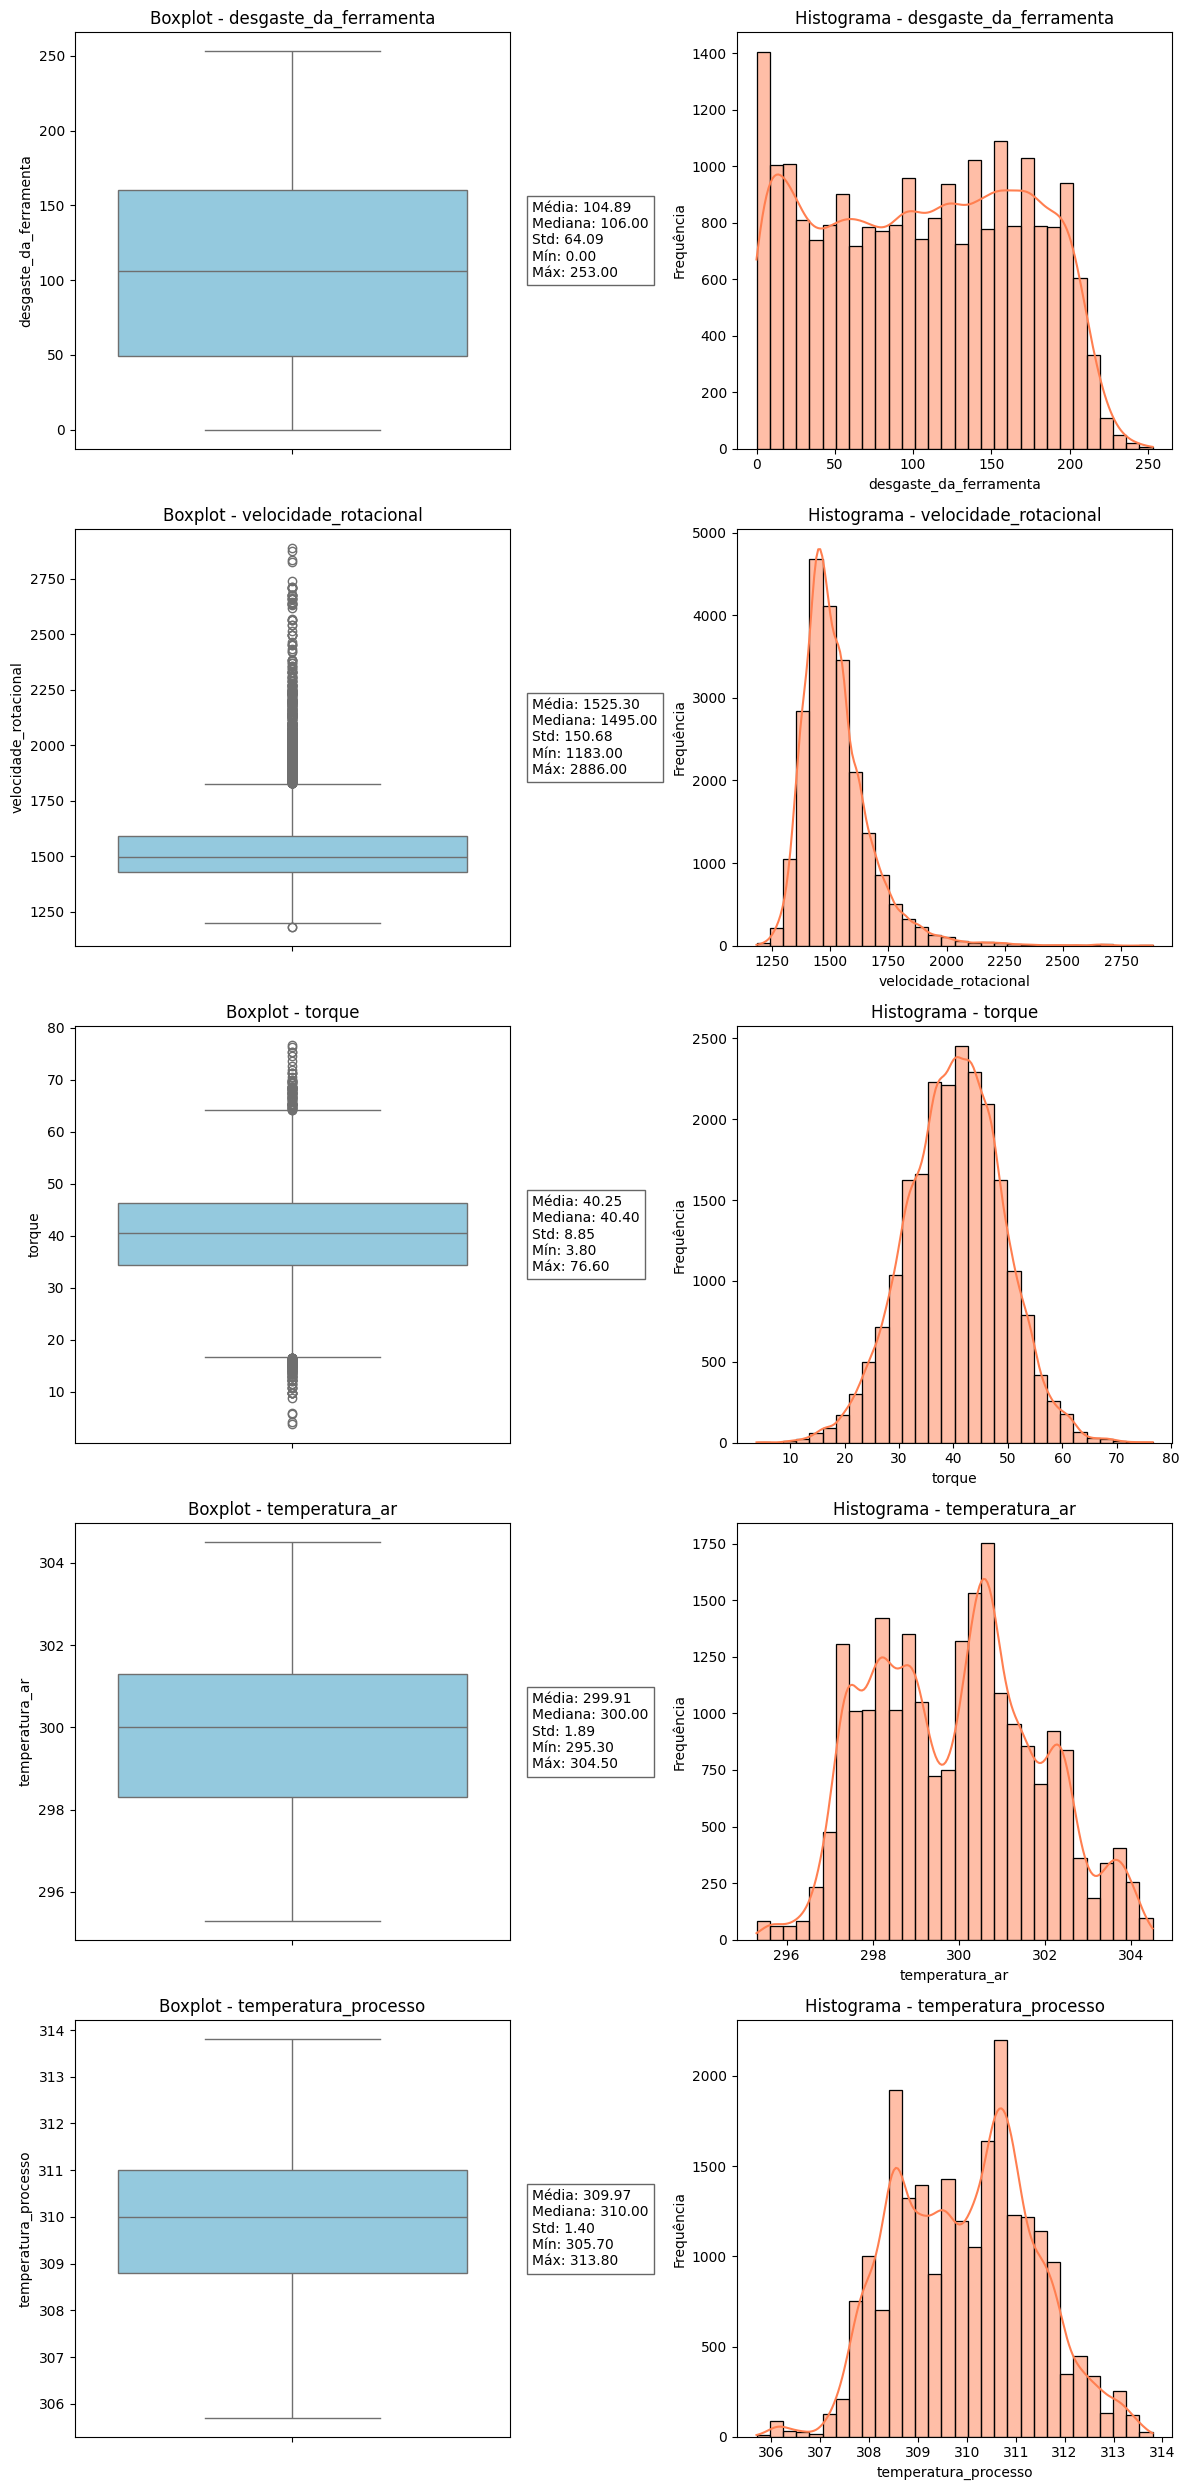

In [86]:
boxplot_com_estatisticas(df_filtrado,['desgaste_da_ferramenta', 'velocidade_rotacional', 'torque', 'temperatura_ar', 'temperatura_processo'] )

In [87]:
#Quantidade de outliers aptos a remoção em cada variável

colunas = ['desgaste_da_ferramenta', 'velocidade_rotacional', 'temperatura_ar', 'temperatura_processo']
impacto_inferior_df = impacto_outliers(df, colunas)
print(impacto_inferior_df)

                   coluna  registros_removidos  percentual_removido
0  desgaste_da_ferramenta                 3439                 9.75
2          temperatura_ar                 3132                 8.88
1   velocidade_rotacional                 2968                 8.42
3    temperatura_processo                 2939                 8.34


#### Anotações.

O número de outliers é alto (35.39% dos dados). Desse antes de excluir esses dados, vamos analisar a matriz de correlação e ver se temos correlação entre variáveis.

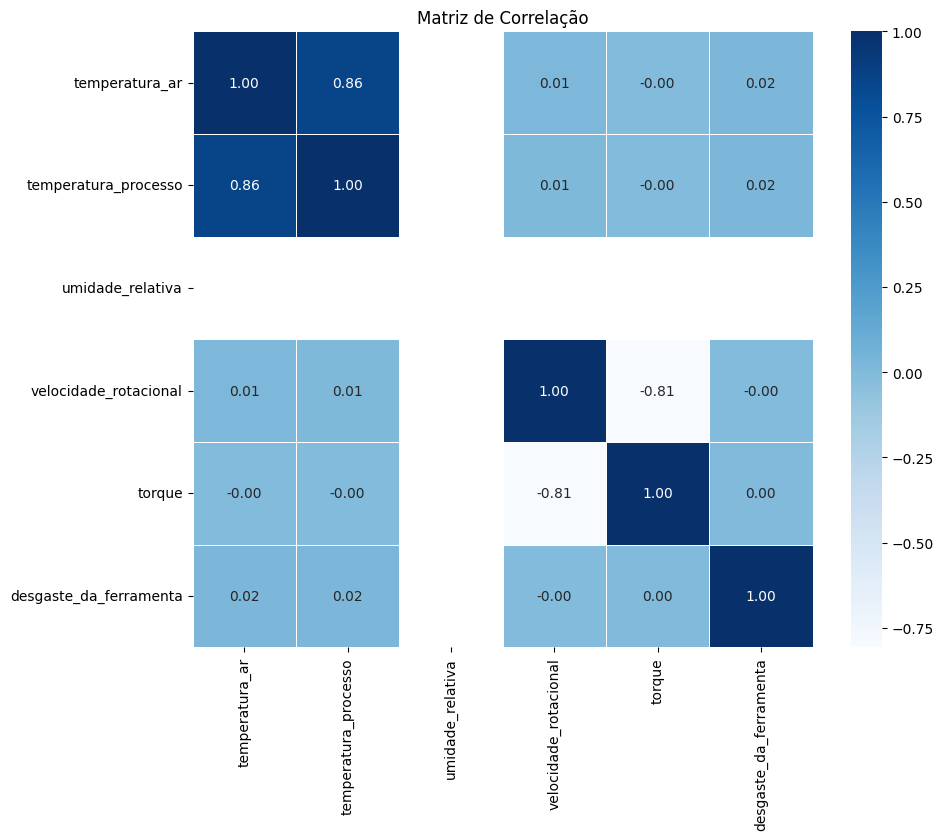

In [89]:
plot_correlation_matrix(df_filtrado)

#### Anotações

Nota-se que as variáveis temperatura_processo e temperatura_ar apresentam correlação forte. Nesse contexto, não faz sentido selecionarmos as duas variáveis para o modelo de machine learning. Optamos por continuar com a variável temperatura_processo pois esta possui um menor percentual de outliers. Vamos refazer o estudo dos outliers, agora sem a coluna temperatura_ar.

In [91]:
df.drop(columns=['temperatura_ar'], inplace=True)

In [92]:
#Remoção dos outliers inferiores

colunas = ['desgaste_da_ferramenta', 'velocidade_rotacional', 'temperatura_processo']

df_filtrado = df.copy()

for col in colunas:
    Q1 = df_filtrado[col].quantile(0.25)
    Q3 = df_filtrado[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_filtrado = df_filtrado[(df_filtrado[col] >= limite_inferior)]

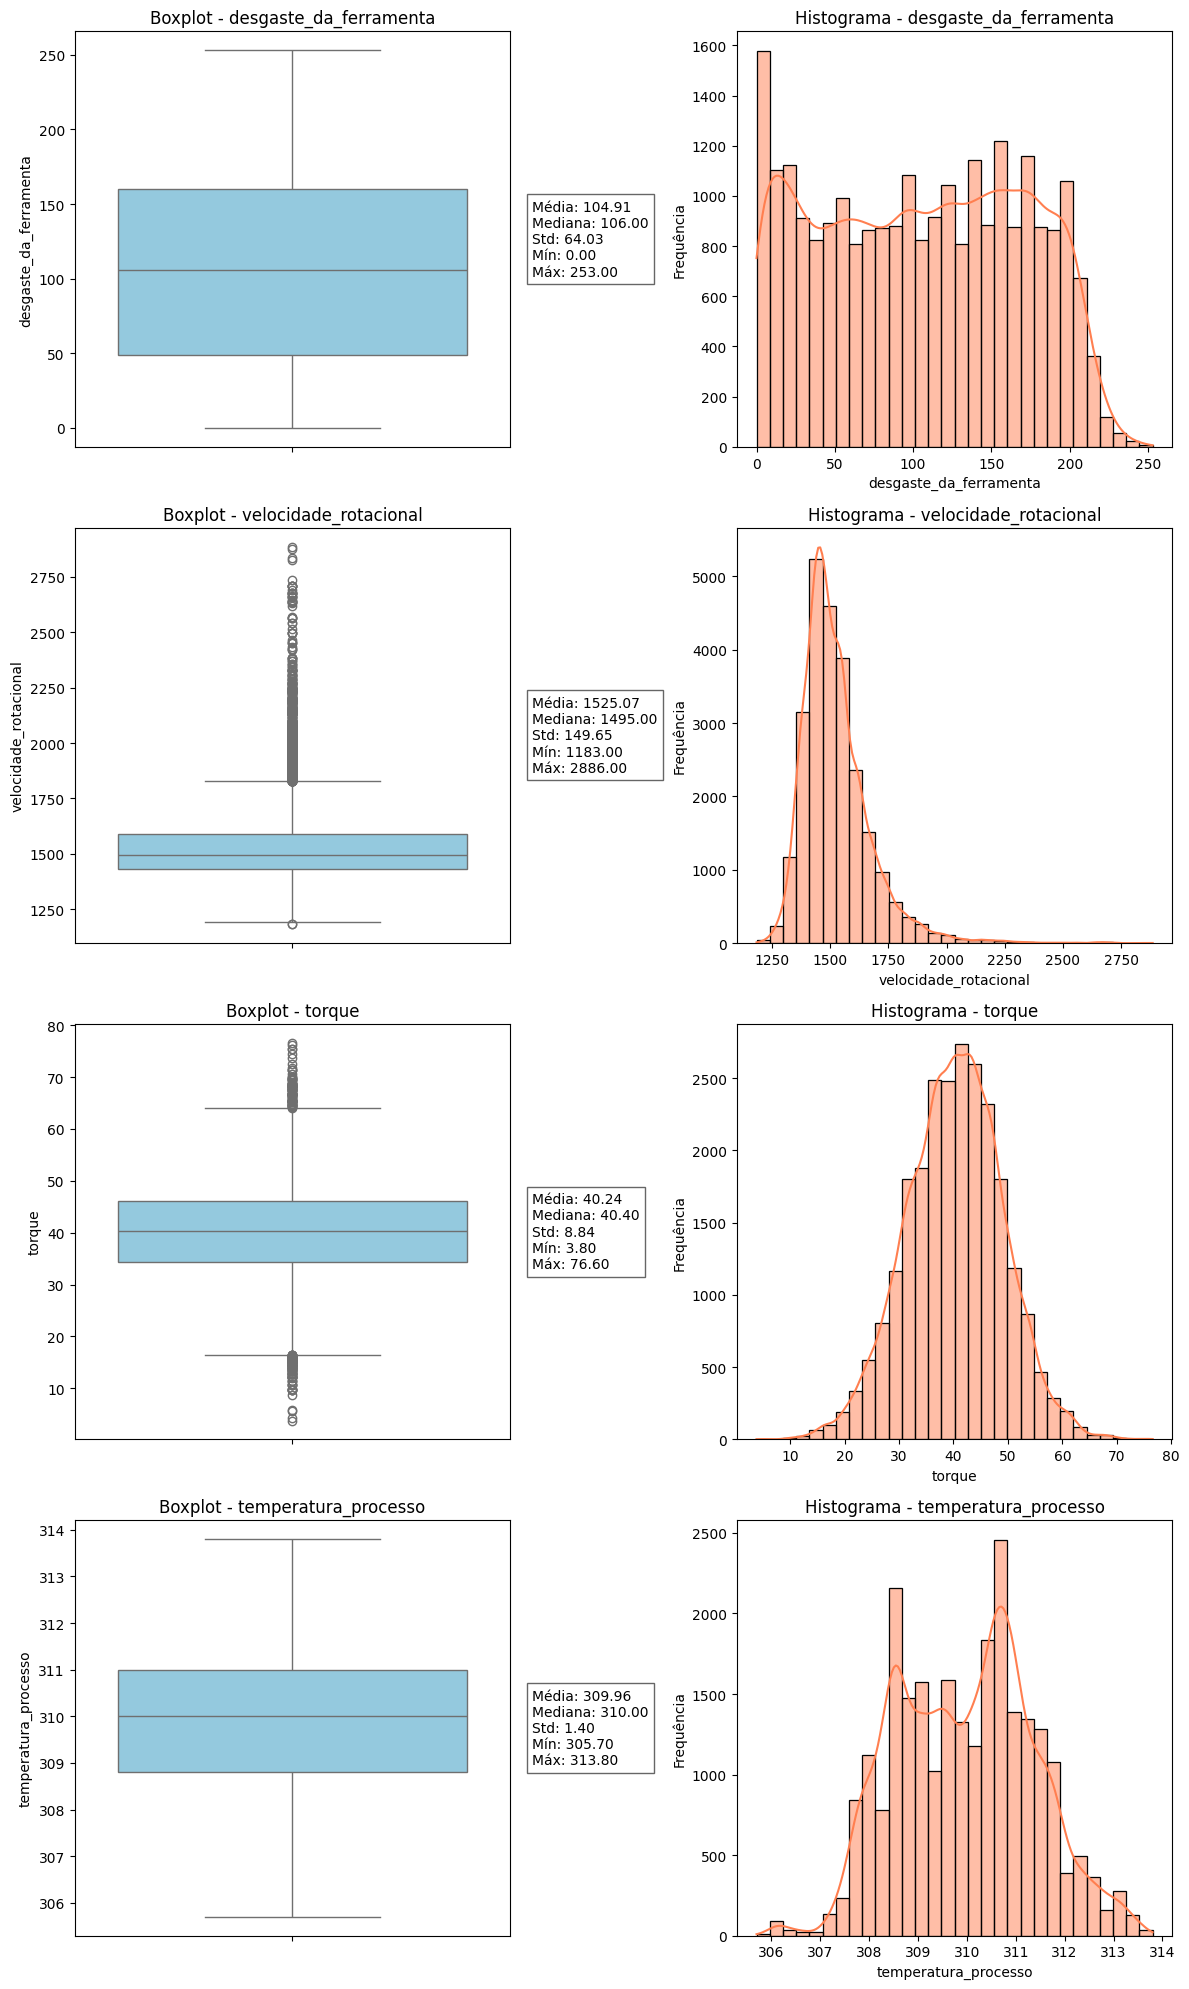

In [93]:
boxplot_com_estatisticas(df_filtrado,['desgaste_da_ferramenta', 'velocidade_rotacional', 'torque', 'temperatura_processo'] )

Desse modo, o conjunto de dados filtrado possui 70.4% dos dados iniciais.

Passamos agora à análise e tratamento dos dados nulos.

In [95]:
df_filtrado.isnull().sum()

,0
id,0
id_produto,0
tipo,0
temperatura_processo,0
umidade_relativa,0
velocidade_rotacional,0
torque,323
desgaste_da_ferramenta,0
falha_maquina,0
FDF (Falha Desgaste Ferramenta),0


De acordo com o que foi analisado, os dados nulos da coluna torque serão substituídos pela média dos dados.

In [96]:
df_filtrado['torque'].fillna(df_filtrado['torque'].mean(), inplace=True)

/tmp/ipython-input-1015066565.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtrado['torque'].fillna(df_filtrado['torque'].mean(), inplace=True)


In [97]:
df_filtrado.isnull().sum()

,0
id,0
id_produto,0
tipo,0
temperatura_processo,0
umidade_relativa,0
velocidade_rotacional,0
torque,0
desgaste_da_ferramenta,0
falha_maquina,0
FDF (Falha Desgaste Ferramenta),0


In [98]:
df_filtrado.describe()

,id,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
count,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000
mean,17544.411334,309.963519,89.996709,1525.074539,40.239030,104.913749
std,10144.359473,1.401467,0.156860,149.649484,8.778465,64.032463
min,0.000000,305.700000,80.590429,1183.000000,3.800000,0.000000
25%,8766.250000,308.800000,90.000000,1430.000000,34.500000,49.000000
50%,17479.500000,310.000000,90.000000,1495.000000,40.300000,106.000000
75%,26268.750000,311.000000,90.000000,1589.000000,46.200000,160.000000
max,35259.000000,313.800000,94.007279,2886.000000,76.600000,253.000000


#### Análise

Observa-se que a variável umidade_relativa possui um desvio padrão muito reduzido em relação à variabilidade esperada dos seus dados. Por isso, sua inclusão no modelo não se mostra relevante.

In [99]:
df_filtrado.drop(columns=['umidade_relativa'], inplace=True)

## Tratamento dos dados: Variáveis target

In [101]:
colunas = ['falha_maquina','FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

In [102]:
# Dados presentes nas variáveis target

for col in colunas:
    print(f"Coluna: {col}")
    print(df[col].unique())
    print("-" * 40)

Coluna: falha_maquina
['não' 'Não' 'sim' 'N' '0' 'Sim' 'y' '1']
----------------------------------------
Coluna: FDF (Falha Desgaste Ferramenta)
['False' 'N' '0' 'True' '-' '1']
----------------------------------------
Coluna: FDC (Falha Dissipacao Calor)
['False' 'nao' '0' 'True' 'y' '1']
----------------------------------------
Coluna: FP (Falha Potencia)
['Não' 'não' 'Sim' 'N' '0' 'sim' '1' 'y']
----------------------------------------
Coluna: FTE (Falha Tensao Excessiva)
[False  True]
----------------------------------------
Coluna: FA (Falha Aleatoria)
['Não' 'não' '0' '-' 'Sim' 'sim' '1']
----------------------------------------


In [104]:
#Tratamento dos dados presentes nas variáveis target

for c in colunas:
    df_filtrado[c] = df_filtrado[c].astype(str).str.strip().str.lower()

mapa = {
    'true': 1,
    'sim': 1,
    'false': 0,
    'nao': 0,
    'não': 0,
    's': 1,
    'n': 0,
    '1': 1,
    '0': 0,
    'yes': 1,
    'no': 0,
    'y': 1,
    '-': np.nan,
    'nan': np.nan   # caso apareça string 'nan' depois da conversão
}

# 3. Substituir valores
df_filtrado[colunas] = df_filtrado[colunas].replace(mapa)

df_filtrado.head()

/tmp/ipython-input-507744763.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtrado[colunas] = df_filtrado[colunas].replace(mapa)


,id,id_produto,tipo,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,309.1,1616.0,31.1,195.0,0,0.0,0,0,0,0.0
1,1,L48741,L,308.4,1388.0,53.8,137.0,0,0.0,0,0,0,0.0
3,3,M20947,M,310.8,1599.0,33.0,7.0,0,0.0,0,0,0,0.0
6,6,M23689,M,308.8,1469.0,44.1,150.0,0,0.0,0,0,0,0.0
7,7,L55125,L,311.7,1655.0,32.2,12.0,0,0.0,0,0,0,0.0


In [105]:
#Verificação da existência de nulos

df_filtrado.isnull().sum()

,0
id,0
id_produto,0
tipo,0
temperatura_processo,0
velocidade_rotacional,0
torque,0
desgaste_da_ferramenta,0
falha_maquina,0
FDF (Falha Desgaste Ferramenta),38
FDC (Falha Dissipacao Calor),0


In [106]:
#Substituição dos nulos pela moda de cada coluna.

df_filtrado['FDF (Falha Desgaste Ferramenta)'].fillna(df_filtrado['FDF (Falha Desgaste Ferramenta)'].mode()[0], inplace=True)
df_filtrado['FA (Falha Aleatoria)'].fillna(df_filtrado['FA (Falha Aleatoria)'].mode()[0], inplace=True)

/tmp/ipython-input-1740804645.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtrado['FDF (Falha Desgaste Ferramenta)'].fillna(df_filtrado['FDF (Falha Desgaste Ferramenta)'].mode()[0], inplace=True)
/tmp/ipython-input-1740804645.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [107]:
df_filtrado.isnull().sum()

,0
id,0
id_produto,0
tipo,0
temperatura_processo,0
velocidade_rotacional,0
torque,0
desgaste_da_ferramenta,0
falha_maquina,0
FDF (Falha Desgaste Ferramenta),0
FDC (Falha Dissipacao Calor),0


In [109]:
df_filtrado[['FDF (Falha Desgaste Ferramenta)','FA (Falha Aleatoria)']] = df_filtrado[['FDF (Falha Desgaste Ferramenta)','FA (Falha Aleatoria)']].astype(float).astype(int)

##Modelo

Agora nosso conjunto de dados está pronto para ser usado em modelos de machine learning.

In [44]:
#Transformação da coluna tipo em numérica
le = LabelEncoder()
df_filtrado['tipo'] = le.fit_transform(df_filtrado['tipo'])

In [45]:
df_filtrado.drop(columns=['id', 'id_produto'], inplace=True)

#### Anotações

Nessa análise vamos considerar que houve falha da máquina e nosso objetivo é encontrar as probabilidades das respectivas causas.

Num primeiro modelo, conseguimos um desempenho geral bom - ROC-AUC ~0.9. Mas temos o problema de desbalanceamento de classes. A variável target 'FA (Falha Aleatoria)' apresenta somente um registro. Nesse caso, vamos tirá-la da análise.

In [47]:
df_filtrado = df_filtrado[(df_filtrado['FA (Falha Aleatoria)']==0)]
df_filtrado.drop(columns=['FA (Falha Aleatoria)'], inplace=True)

In [49]:
# =============================
# 1. Filtrar apenas quando houve falha
# =============================
df_falhas = df_filtrado[df_filtrado['falha_maquina'] == 1].reset_index(drop=True)

# =============================
# 2. Definir X (features) e Y (causas)
# =============================
causas = ['FDF (Falha Desgaste Ferramenta)','FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)']

X = df_falhas.drop(columns=['falha_maquina'] + causas).values
Y = df_falhas[causas].values

# =============================
# 3. Split treino/teste
# =============================
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# =============================
# 4. Modelo Multi-label
# =============================
base_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
modelo = MultiOutputClassifier(base_model)
modelo.fit(X_train, Y_train)

# =============================
# 5. Avaliar modelo
# =============================
Y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)
print("🔹 Relatório de classificação:\n")
print(classification_report(Y_test, Y_pred, target_names=causas))

# 🔹 Avaliação
# ==========================
print("Subset Accuracy:", accuracy_score(Y_test, Y_pred))
print("Hamming Loss:", hamming_loss(Y_test, Y_pred))

print("\n📊 Relatório por classe (precision, recall, f1):")
print(classification_report(Y_test, Y_pred, target_names=causas))

# ==========================
# 🔹 ROC-AUC
# ==========================
# predict_proba retorna uma lista de arrays no multi-label
y_proba_all = np.array([p[:,1] for p in y_proba]).T  # probabilidade da classe positiva (1)

roc_auc_macro = roc_auc_score(Y_test, y_proba_all, average="macro")
roc_auc_micro = roc_auc_score(Y_test, y_proba_all, average="micro")


print("\nROC-AUC (macro):", roc_auc_macro)
print("ROC-AUC (micro):", roc_auc_micro)



🔹 Relatório de classificação:

                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.86      0.46      0.60        13
   FDC (Falha Dissipacao Calor)       0.79      0.82      0.81        28
            FP (Falha Potencia)       0.71      0.62      0.67        16
   FTE (Falha Tensao Excessiva)       0.78      0.75      0.77        24

                      micro avg       0.78      0.70      0.74        81
                      macro avg       0.79      0.66      0.71        81
                   weighted avg       0.78      0.70      0.73        81
                    samples avg       0.59      0.59      0.58        81

Subset Accuracy: 0.6451612903225806
Hamming Loss: 0.10752688172043011

📊 Relatório por classe (precision, recall, f1):
                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.86      0.46      0.60        13
   FDC (Falha Dissipacao Calor)       0.79 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

[0.11467742 0.33690814 0.15091492 0.25295699]


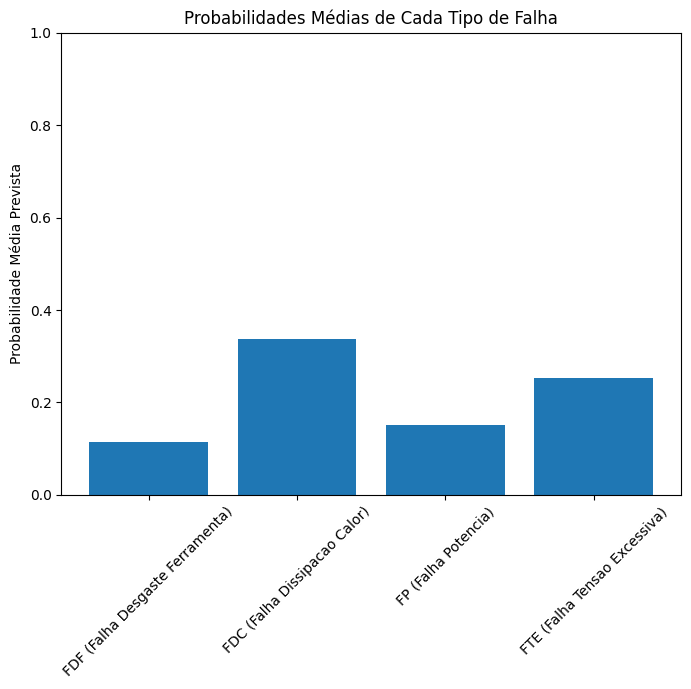

In [51]:
# ==========================
# 🔹 Gráfico com as probabilidades
# ==========================
# Probabilidades médias por falha
mean_proba = y_proba_all.mean(axis=0)

print(mean_proba)

plt.figure(figsize=(8, 6))
plt.bar(causas, mean_proba) # color=['#1f77b4','#ff7f0e','#2ca02c','#d62728'])
#plt.xlabel("Tipo de Falha")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Probabilidade Média Prevista")
plt.title("Probabilidades Médias de Cada Tipo de Falha")
plt.show()

#### Anotações

O modelo apresenta bom desempenho geral(F1 médio igual a 0.71) e possui boa separabilidade global (ROC-AUC >0.90).

Desse modo, conclui-se que, dado que existe uma falha, 11.46% está associada ao FDF, 33.69% a FDC, 15.09% a FP e 25.29% a FTE.

## Análise de modelos de classificação para estudo da melhor ferramenta de classificação para existência de falhas.

In [54]:
#Features e target
causas = ['FDF (Falha Desgaste Ferramenta)','FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)']

X = df_filtrado.drop(columns=['falha_maquina'] + causas)
y = df_filtrado['falha_maquina']

#Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [63]:
#Distribuição dos dados após split
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24789, 5), (24789,), (19831, 5), (4958, 5), (19831,), (4958,))


===== Logistic Regression =====
Confusion Matrix:
 [[3754 1112]
 [  26   66]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      4866
           1       0.06      0.72      0.10        92

    accuracy                           0.77      4958
   macro avg       0.52      0.74      0.49      4958
weighted avg       0.98      0.77      0.85      4958

ROC-AUC: 0.8295
PR-AUC: 0.1757
F1 (classe 1): 0.1039

===== Random Forest =====
Confusion Matrix:
 [[4860    6]
 [  79   13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      4866
           1       0.68      0.14      0.23        92

    accuracy                           0.98      4958
   macro avg       0.83      0.57      0.61      4958
weighted avg       0.98      0.98      0.98      4958

ROC-AUC: 0.9134
PR-AUC: 0.3788
F1 (classe 1): 0.2342
[LightGBM] [Info] Number of positive: 

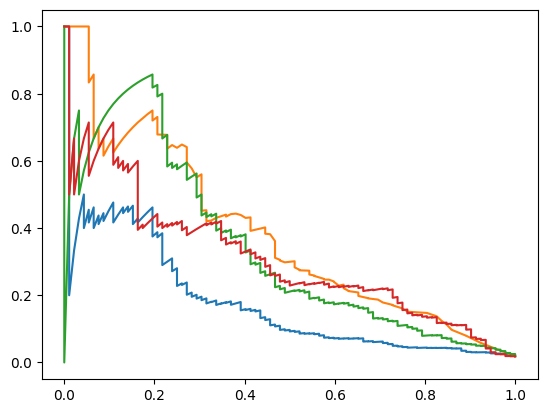

In [57]:
# ========= Treinar modelos =========
resultados = []

# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
resultados.append(avaliar_modelo("Logistic Regression", log_reg, X_train, y_train, X_test, y_test))

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
resultados.append(avaliar_modelo("Random Forest", rf, X_train, y_train, X_test, y_test))

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
resultados.append(avaliar_modelo("LightGBM", lgb_model, X_train, y_train, X_test, y_test))

# CatBoost
cat = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_state=42,
    class_weights=[1, sum(y_train==0)/sum(y_train==1)]  # balanceamento manual
)
resultados.append(avaliar_modelo("CatBoost", cat, X_train, y_train, X_test, y_test))


# ========= Comparação final =========

print("\nResumo dos modelos:")
for r in resultados:
    print(r)

### Análise

Com base nos modelos comparados, optamos pela escolha do modelo CatBoost.

Sua matriz de confusão: [[4382  484]
                         [17     75]]
mostra que 4382 foram corretamente previstos (casos que não possuem falha e foram corretamente classificados), 484 casos foram incorretamente identificados (casos que não possuem falha, mas o sistema classificou como se tivesse falha - Chamamos essa classificação de "Alarme Falso"), 75 casos corretamente previstos (casos que houve falha e o sistema corretamente identificado pelo sistema) e 17 casos incorretamente previstos (Casos que houve falha, mas o sistema classificou de forma errada).

Apesar de poucas falhas, o modelo conseguiu um recall de 82%, ou seja, captura a maior parte dos casos de falha. A métrica ROC-AUC = 91.33% indica uma boa separação global entre as classes. Dessa forma, o modelo consegue rankear bem as probabilidades.






#Verificação em Base de Teste

In [64]:
uploaded = files.upload()

Saving bootcamp_test.csv to bootcamp_test.csv


In [125]:
df_teste = pd.read_csv('bootcamp_test.csv')

In [126]:
df_teste.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
0,35260,L53432,L,300.8,310.3,90.0,1538,36.1,198
1,35261,M19544,M,303.6,311.8,90.0,1421,44.8,101
2,35262,M16591,M,298.3,307.9,90.0,1485,42.0,117
3,35263,L51922,L,303.3,311.3,90.0,1592,33.7,14
4,35264,L51701,L,302.4,310.4,90.0,1865,23.9,129


In [127]:
#Tratamento de df_teste como feito para df_train na preparação do modelo

df_teste_filtrado = df_teste.copy()
df_teste_filtrado.drop(columns=['temperatura_ar'], inplace=True)
df_teste_filtrado.drop(columns=['umidade_relativa'], inplace=True)
df_teste_filtrado['velocidade_rotacional'] = df_teste_filtrado['velocidade_rotacional'].astype(float)
df_teste_filtrado['desgaste_da_ferramenta'] = df_teste_filtrado['desgaste_da_ferramenta'].astype(float)
df_teste_filtrado['tipo'] = le.fit_transform(df_teste_filtrado['tipo'])
df_teste_filtrado.drop(columns=['id', 'id_produto'], inplace=True)
df_teste_filtrado.head()

,tipo,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta
0,1,310.3,1538.0,36.1,198.0
1,2,311.8,1421.0,44.8,101.0
2,2,307.9,1485.0,42.0,117.0
3,1,311.3,1592.0,33.7,14.0
4,1,310.4,1865.0,23.9,129.0


In [128]:
#Verificação da similaridade dos heads dos dataframes
X_test.head()

,tipo,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta
19685,1,309.3,1442.0,43.9,18.0
35226,2,310.2,1478.0,42.4,5.0
27703,1,308.5,1483.0,45.7,109.0
26112,2,309.8,1401.0,45.0,200.0
28666,1,310.7,1608.0,33.3,21.0


In [130]:
# Predição de fato utilizando os modelos treinados
y_pred_log_reg = log_reg.predict(df_teste_filtrado)
y_pred_rf = rf.predict(df_teste_filtrado)
y_pred_lgb_model = lgb_model.predict(df_teste_filtrado)
y_pred_cat = cat.predict(df_teste_filtrado)

In [131]:
df_teste['pred_cat'] = y_pred_cat
df_teste['pred_log_reg'] = y_pred_log_reg
df_teste['pred_rf'] = y_pred_rf
df_teste['pred_lgb_model'] = y_pred_lgb_model
df_teste.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,pred_cat,pred_log_reg,pred_rf,pred_lgb_model
0,35260,L53432,L,300.8,310.3,90.0,1538,36.1,198,0,0,0,0
1,35261,M19544,M,303.6,311.8,90.0,1421,44.8,101,0,0,0,0
2,35262,M16591,M,298.3,307.9,90.0,1485,42.0,117,0,0,0,0
3,35263,L51922,L,303.3,311.3,90.0,1592,33.7,14,0,0,0,0
4,35264,L51701,L,302.4,310.4,90.0,1865,23.9,129,0,0,0,0
